In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.random import PRNGKey

jax.config.update("jax_enable_x64", True)

from maker import get_model, yield_maker
from relaxed import infer

plt.rc("figure", figsize=(10.0, 6.0), dpi=120, facecolor="w")

In [2]:
SCALE = 10000

N = 270 * SCALE


def generate_data(key):
    b1 = jax.random.multivariate_normal(
        key, jnp.array([+1.0, +0.0]), np.eye(2), shape=(N // 4,)
    )
    b2 = jax.random.multivariate_normal(
        key, jnp.array([+0.0, +0.0]), np.eye(2), shape=(N // 4,)
    )
    b3 = jax.random.multivariate_normal(
        key, jnp.array([-1.0, -0.0]), np.eye(2), shape=(N // 4,)
    )

    s1 = jax.random.multivariate_normal(
        key, jnp.array([3.0, 0.0]), np.eye(2), shape=(N // 16,)
    )

    return s1, b1, b2, b3


generate_data(PRNGKey(3))[0] @ jnp.array([1, 1])

DeviceArray([4.17737466, 0.54657334, 2.03176818, ..., 4.02444665,
             2.09741342, 2.88617482], dtype=float64)

In [3]:
bins = np.asarray([-5, 0, 5])

yields = yield_maker(generate_data, bins=bins, SCALE=SCALE)
model_maker = get_model(yields)
hypotest = infer.make_hypotest(model_maker)
hypotest([0.2, 0.2], model_kwargs=dict(key=PRNGKey(3)), test_mu=1.0)

{'CLs': DeviceArray(0.04837478, dtype=float64)}

In [4]:
def loss_fn(params, model_kwargs):
    return hypotest(params, model_kwargs=model_kwargs, test_mu=1.0)["CLs"]


def grad_descent(current_params, loss, lr=2):
    current_cls, grad = jax.value_and_grad(loss)(current_params)
    params = current_params - grad * lr
    return params, current_params, current_cls, grad

without plotting:

In [5]:
x = jnp.array([0.1, 0.1])
new_key = PRNGKey(3)
for i in range(2):
    new_key, subkey = jax.random.split(new_key)
    loss = partial(loss_fn, model_kwargs=dict(key=subkey))
    x, current_x, cls, grad = grad_descent(x, loss, lr=8)
    print(cls, current_x)

0.052979535802949895 [0.1 0.1]
0.047763292362864807 [0.54738631 0.10113828]


With plotting!

In [10]:
data = {
    "Data space": [],
    "Training trajectory": [],
    "Histogram model": [],
    "CLs per epoch": [],
}


def plot_data_space(ax, params, key):
    angle, anchr = params

    anchr = jnp.array([anchr, 0.0])

    s1, b1, b2, b3 = generate_data(key)
    ax.scatter(b1[:, 0], b1[:, 1], alpha=0.2, color="C0")
    ax.scatter(b2[:, 0], b2[:, 1], alpha=0.2, color="slategrey")
    ax.scatter(b3[:, 0], b3[:, 1], alpha=0.2, color="slategrey")
    ax.scatter(s1[:, 0], s1[:, 1], alpha=0.2, color="C1")

    ax.scatter(anchr[0], anchr[1], c="C3")
    # for angle in [0.0, jnp.pi / 4, jnp.pi / 2]:

    direc = jnp.array([jnp.cos(angle), jnp.sin(angle)])
    normal = jnp.array([jnp.cos(angle + jnp.pi / 2), jnp.sin(angle + jnp.pi / 2)])

    lp = jax.vmap(lambda alpha: anchr + alpha * direc)(jnp.linspace(-5, 5))
    ax.plot(lp[:, 0], lp[:, 1], c="k")

    t = np.stack([anchr, anchr + normal])
    # ax.plot(t[:, 0], t[:, 1], c="yellow")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)


def plot_training(ax, angle, anchr, cls):
    ax.plot(angle, anchr, cls, color="C6")


def plot_cls(ax, epoch, cls):
    ax.plot(epoch, cls, color="C9")


def plot_hist(ax, params, key):
    ns1, nb1, nb2, nb3 = yields(params, key)
    centres = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]
    ax.bar(centres, nb1, width=bin_width, color="C0")
    ax.bar(centres, ns1, bottom=nb1, width=bin_width, color="C1")
    ax.bar(centres, nb2, alpha=0.4, color="slategrey", width=bin_width)
    ax.bar(centres, nb3, alpha=0.4, color="slategrey", width=bin_width)

In [11]:
def plot_epoch(axs, data, key):

    label = "Data space"
    plot_data_space(axs[label], data[label], key)

    label = "Training trajectory"
    all_data = np.asarray(data[label]).T
    plot_training(axs[label], *all_data)

    label = "Histogram model"
    plot_hist(axs[label], data[label], key)

    label = "CLs per epoch"
    all_data = np.asarray(data[label]).T
    plot_cls(axs[label], *all_data)

0.052979535802949895 [0.1 0.1]
0.047763292362864807 [0.54738631 0.10113828]
0.04679306400418426 [0.48149631 0.16293101]
0.04627414330256707 [0.43460221 0.21661894]
0.04591750838138031 [0.40689146 0.26087024]


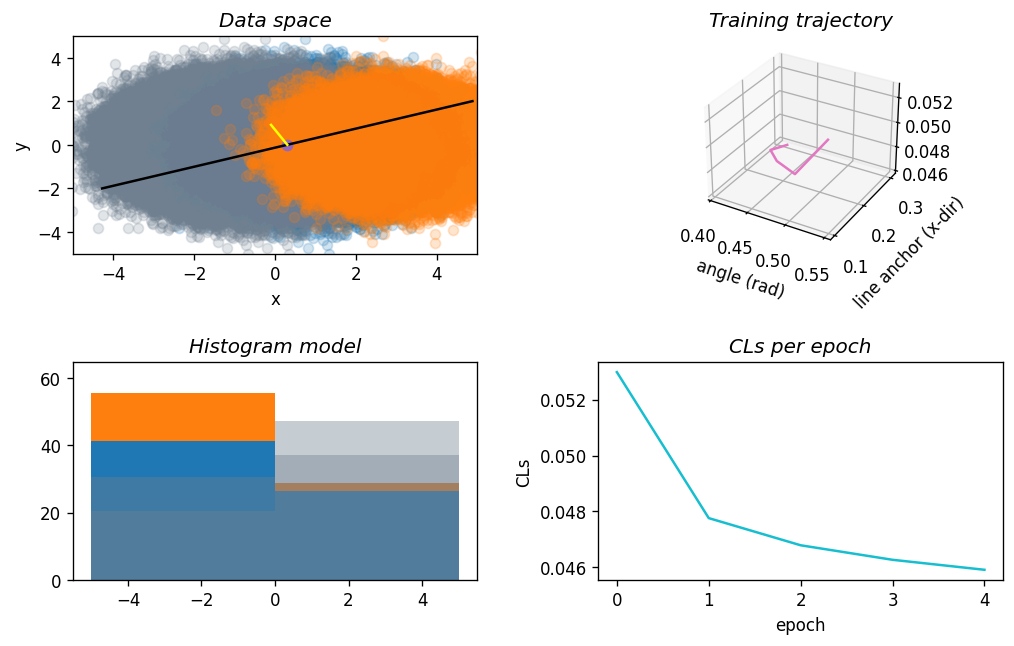

In [12]:
fig, axs = plt.subplot_mosaic(
    [["Data space", "Training trajectory"], ["Histogram model", "CLs per epoch"]]
)

ss = axs["Training trajectory"].get_subplotspec()
axs["Training trajectory"].remove()
axs["Training trajectory"] = fig.add_subplot(ss, projection="3d")

for label, ax in axs.items():
    ax.set_title(label, fontstyle="italic")
axs["Training trajectory"].set_xlabel("angle (rad)")
axs["Training trajectory"].set_ylabel("line anchor (x-dir)")
axs["Data space"].set_xlabel("x")
axs["Data space"].set_ylabel("y")
axs["CLs per epoch"].set_xlabel("epoch")
axs["CLs per epoch"].set_ylabel("CLs")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_constrained_layout(False)

ax_copy = axs

from celluloid import Camera

camera = Camera(fig)

# training loop
x = jnp.array([0.1, 0.1])
new_key = PRNGKey(3)

data["Data space"].append([x, new_key])

for i in range(5):
    new_key, subkey = jax.random.split(new_key)
    loss = partial(loss_fn, model_kwargs=dict(key=subkey))
    x, current_x, cls, grad = grad_descent(x, loss, lr=8)

    data["Data space"] = x
    data["Training trajectory"].append([*x, cls])
    data["CLs per epoch"].append([i, cls])
    data["Histogram model"] = x

    plot_epoch(axs, data, subkey)
    camera.snap()
    axs = ax_copy
    print(cls, current_x)

camera.animate().save("ani2.gif", writer="imagemagick", fps=8)